## Introdução
O EP3 tem dois objetivos principais: 

Parte 3.1- Segmentação do objeto de interesse: O objetivo desta etapa é segmentar o  objeto do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Dois tipos de segmentação serão usados: manual, para geração do ground-truth, e automática usando algum algoritmo de sua escolha. 

Parte 3.2- Classificação do objeto de interesse. Ou seja, aplicar PCA e SVM para classificar os objetos entre as classes definidas.

Nas duas etapas, a acurácia das soluções serão calculadas.

## Header 3.1

Parte 3.1- Segmentação do objeto de interesse: O objetivo desta etapa é segmentar o  objeto do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Dois tipos de segmentação serão usados: manual, para geração do ground-truth, e automática usando algum algoritmo de sua escolha. 

O ground-truth deve ser gerado para pelo menos 15% das amostras de cada classe. Ferramentas possíveis para geração do ground-truth:

a) utilizar um software de edição de imagens como o GIMP, Paint, etc.

b) programas de geração de ground-truth  (eg. programa do Eduardo, supervise , labelstudio, etc.)


--------------------
Autores: Luan Carlos da Silva Casagrande
Paulo Henrique da Silveira
Yoshio Mori

## Constantes

## Segmentação Automática

Bibliotécas necessárias

In [3]:
import pathlib

from skimage import io
from skimage import morphology
from skimage import filters
from skimage import feature
from skimage import segmentation
from matplotlib import pyplot
import numpy
import math

Iremos trabalhar encima da seguinte imagem

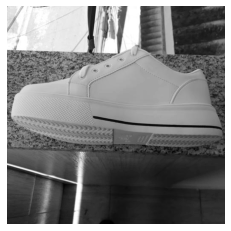

In [4]:
image_path = pathlib.Path(r"originalGrayDataset\TENIS\DIA\DENTRO\GRANITO\20210424_114639.jpg")
image = io.imread(image_path)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)

Iremos montar uma imagem degradê, claro no centro, escuro nas bordas

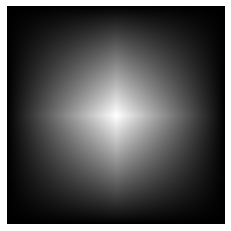

In [5]:
w, h = image.shape
l, c = divmod(numpy.arange(math.prod(image.shape)).reshape(image.shape), w)

l = l.astype(numpy.float64)
lb = l * (l <= w/2)
lb *= 1 / numpy.max(lb)
la = l * (l > w/2)
la = numpy.max(la) - la
la *= (l > w/2)
la -= numpy.min(la)
la *= (l > w/2)
la /= numpy.max(la)

c = c.astype(numpy.float64)
cb = c * (c <= w/2)
cb *= 1 / numpy.max(cb)
ca = c * (c > w/2)
ca = numpy.max(ca) - ca
ca *= (c > w/2)
ca -= numpy.min(ca)
ca *= (c > w/2)
ca /= numpy.max(ca)

mask = (lb + la) * (cb + ca)
pyplot.axis('off')
pyplot.imshow(mask, cmap=pyplot.cm.gray)

Iremos aplicar a máscara na imagem

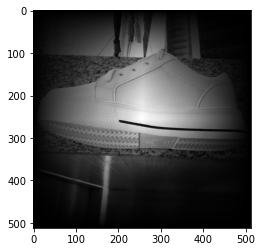

In [6]:
imageWithMask = image * mask
pyplot.imshow(imageWithMask, cmap=pyplot.cm.gray)

Iremos aplicar o método de limiarização de Otsu

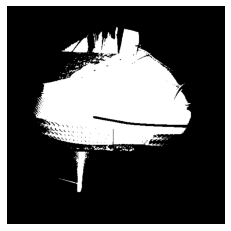

In [7]:
thresh = filters.threshold_otsu(imageWithMask)
binary = imageWithMask > thresh
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos inverter as cores, pois skimage entende que em branco é a imagem e preto é o fundo

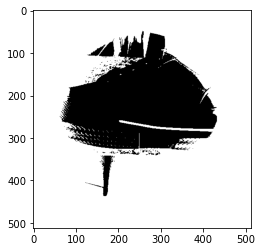

In [8]:
binary_inverted = numpy.invert(binary)
pyplot.imshow(binary_inverted, cmap=pyplot.cm.gray)

Aplicaremos novamente a máscara e aplicaremos o filtro passa alta, para remover o fundo completamente

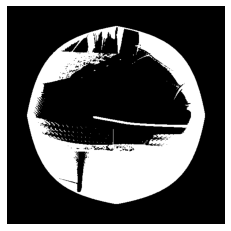

In [9]:
binary_inverted = binary_inverted * mask
thresh = filters.threshold_otsu(binary_inverted)
binary_inverted = binary_inverted > thresh
pyplot.axis('off')
pyplot.imshow(binary_inverted, cmap=pyplot.cm.gray)

Para deixar a função mais genérica iremos assumir que o fundo sempre será a maior parte da imagem.

Assumiremos também que o objeto é branco e o fundo é preto.

Assim iremos sempre usar a imagem cuja média tem o menor valor.

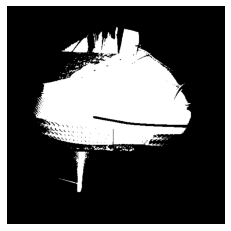

In [10]:
mean_binary = numpy.mean(binary)
mean_binary_inverted = numpy.mean(binary_inverted)
if mean_binary > mean_binary_inverted:
    binary = binary_inverted
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos aplicar a operação morfológica de erosão para remover possíveis ruídos e depois reconstruir a partir da imagem de saída

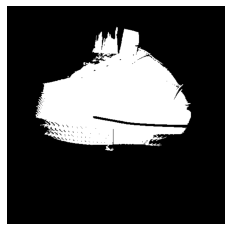

In [11]:
binary_erosion = morphology.erosion(binary, morphology.disk(25))
binary = morphology.reconstruction(binary_erosion, binary)
pyplot.axis('off')
pyplot.imshow(binary, cmap=pyplot.cm.gray)

Iremos compilar tudo em uma única função, mas com um detalhe comentado no código abaixo

In [6]:
def segmentacao(image_ndarray):
    w, h = image_ndarray.shape
    l, c = divmod(numpy.arange(math.prod(image_ndarray.shape)).reshape(image_ndarray.shape), w)

    l = l.astype(numpy.float64)
    lb = l * (l <= w/2)
    lb *= 1 / numpy.max(lb)
    la = l * (l > w/2)
    la = numpy.max(la) - la
    la *= (l > w/2)
    la -= numpy.min(la)
    la *= (l > w/2)
    la /= numpy.max(la)

    c = c.astype(numpy.float64)
    cb = c * (c <= w/2)
    cb *= 1 / numpy.max(cb)
    ca = c * (c > w/2)
    ca = numpy.max(ca) - ca
    ca *= (c > w/2)
    ca -= numpy.min(ca)
    ca *= (c > w/2)
    ca /= numpy.max(ca)

    mask = (lb + la) * (cb + ca)
    
    imageWithMask = image_ndarray * mask
    
    thresh = filters.threshold_otsu(imageWithMask)
    binary = imageWithMask > thresh
    
    binary_inverted = numpy.invert(binary)
    
    binary_inverted = binary_inverted * mask
    thresh = filters.threshold_otsu(binary_inverted)
    binary_inverted = binary_inverted > thresh
    
    mean_binary = numpy.mean(binary)
    mean_binary_inverted = numpy.mean(binary_inverted)
    if mean_binary > mean_binary_inverted:
        binary = binary_inverted
    
    binary_erosion = morphology.erosion(binary, morphology.disk(25))
    binary = morphology.reconstruction(binary_erosion, binary)
    return binary

Iremos testar a função de segmetação para alguma imagens

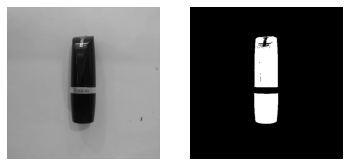

In [13]:
image_path = pathlib.Path(r"originalGrayDataset\BATOM\DIA\DENTRO\BRANCO\IMG_20210501_143727.jpg")
image = io.imread(image_path)
pyplot.subplot(1,2,1)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)
pyplot.subplot(1,2,2)
pyplot.axis('off')
pyplot.imshow(segmentacao(image), cmap=pyplot.cm.gray)

Vamos aplicar a função de segmentação para outra imagem

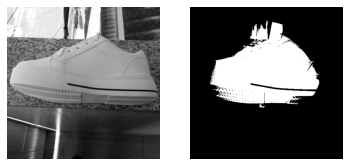

In [14]:
image_path = pathlib.Path(r"originalGrayDataset\TENIS\DIA\DENTRO\GRANITO\20210424_114639.jpg")
image = io.imread(image_path)
pyplot.subplot(1,2,1)
pyplot.axis('off')
pyplot.imshow(image, cmap=pyplot.cm.gray)
pyplot.subplot(1,2,2)
pyplot.axis('off')
pyplot.imshow(segmentacao(image), cmap=pyplot.cm.gray)

Agora aplicaremos para todo originalGrayDataset

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\BATOM\DIA\FORA\MARROM\IMG_20210501_122633.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\BATOM\DIA\FORA\MARROM\IMG_20210501_122634_2.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Ran

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CAIXA DE CHA\DIA\FORA\FUNDO 1\20210511_145434.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CAIXA DE CHA\DIA\FORA\FUNDO 1\20210511_145437.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CAIXA DE CHA\NOITE\DENTRO\FUNDO 3\20210511_200247.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to su

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CANECA\DIA\DENTRO\FUNDO 3\20210511_144334.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress t

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CANECA\NOITE\FORA\FUNDO 1\20210511_200449.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress t

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CANETA\DIA\FORA\GRANITO\20210508_143921(0).jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\DIA\DENTRO\GELO LISTRAS\IMG_20210501_123552.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\DIA\DENTRO\GELO LISTRAS\IMG_20210501_123600.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\DIA\FORA\GELO LISTRAS\IMG_20210501_113233.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\DIA\FORA\GELO LISTRAS\IMG_20210501_113311.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-inpu

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\NOITE\FORA\BRANCO\IMG_20210501_145416.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\CARRETEIS PESCA\NOITE\FORA\BRANCO\IMG_20210501_145417_1.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion fr

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\GARFO\DIA\DENTRO\BRANCO\20210424_120144(0).jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning:

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\GARFO\NOITE\FORA\BRANCO\20210424_181347.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\GARFO\NOITE\FORA\BRANCO\20210424_181348.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\GARFO\NOITE\FORA\GRANITO\20210424_183818.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\GARFO\NOITE\FORA\GRANITO\20210424_183830.j

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\LIVRO\DIA\FORA\FUNDO 1\20210511_145212.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\LIVRO\DIA\FORA\FUNDO 1\20210511_145216.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: au

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\LIVRO\NOITE\FORA\FUNDO 1\20210511_200416.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress th

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\PARAFUSO\DIA\DENTRO\GRANITO\20210424_113930.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\PARAFUSO\NOITE\FORA\GRANITO\20210424_184006.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\DIA\DENTRO\MARROM\IMG_20210501_125925.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\DIA\DENTRO\MARROM\IMG_20210501_125929.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 t

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\DIA\FORA\GELO LISTRAS\IMG_20210501_113936.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\DENTRO\BRANCO\IMG_20210501_153450.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\DENTRO\BRANCO\

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\DENTRO\MARROM\IMG_20210501_155622.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\DENTRO\MARROM\IMG_20210501_155623.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float

<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\FORA\GELO LISTRAS\IMG_20210501_144427.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\FORA\GELO LISTRAS\IMG_20210501_144427_1.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-15-27ad7cd727d1>:11: UserWarning: autoSegmentation\TAMPA 74MM\NOITE\FORA\GELO LISTRAS\IMG_20210501_144428.jpg is a low contrast image
  io.imsave(image_path, segmentacao(image))
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

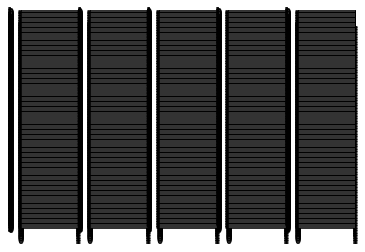

In [15]:
original_gray_dataset_path = pathlib.Path('originalGrayDataset')
path_list = list(original_gray_dataset_path.glob('**/*.jpg'))
n_col = 5
n_lin = math.ceil(len(path_list) / n_col)
fig, ax = pyplot.subplots(n_lin, n_col)
for index, path in enumerate(path_list):
    image = io.imread(path)
    image_path = pathlib.Path(str(path).replace('originalGrayDataset', 'autoSegmentation'))
    if not image_path.exists():
        image_path.parent.mkdir(parents=True, exist_ok=True)
        io.imsave(image_path, segmentacao(image))

Feret_box function
Calcula linha minima, linha maxima, coluna minima e coluna maxima e retorna uma tuple com esses valores

In [7]:
import numpy as np 

def feret_box(image_ndarray):
    res = np.argwhere(image_ndarray > 0) 

    minLine = min(res[:, 0])
    maxLine = max(res[:, 0])
    minColumn = min(res[:, 1])
    maxColumn = max(res[:, 1])    
    
    return (minLine, maxLine, minColumn, maxColumn)


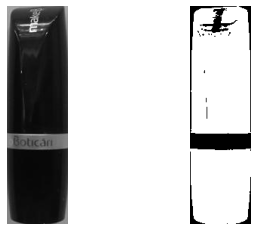

In [8]:
image_path = pathlib.Path(r"originalGrayDataset\BATOM\DIA\DENTRO\BRANCO\IMG_20210501_143727.jpg")

image = io.imread(image_path)
seg = segmentacao(image)
bb = feret_box(seg)
aux = image[bb[0]:bb[1], bb[2]:bb[3]]
bbseg = seg[bb[0]:bb[1], bb[2]:bb[3]]

pyplot.subplot(1,2,1)
pyplot.axis('off')
pyplot.imshow(aux, cmap=pyplot.cm.gray)
pyplot.subplot(1,2,2)
pyplot.axis('off')
pyplot.imshow(bbseg, cmap=pyplot.cm.gray)

In [19]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_calc(in_reference, in_predicted):
    return confusion_matrix(in_reference, in_predicted, labels=[0,1])

In [20]:
from sklearn.metrics import classification_report

def metrics(in_reference, in_predicted):
    return classification_report(in_reference, in_predicted, labels=[0,1], output_dict=True)

In [11]:
image_path = pathlib.Path(r"originalGrayDataset\BATOM\DIA\DENTRO\BRANCO\IMG_20210501_143728.jpg")
image_path_ref = pathlib.Path(r"originalGrayDataset15porcento_mod_res\BATOM\DIA\DENTRO\BRANCO\IMG_20210501_143728.png")

image = io.imread(image_path)
seg = segmentacao(image)
bb = feret_box(seg)
seg = seg[bb[0]:bb[1], bb[2]:bb[3]]

image_ref = io.imread(image_path_ref)
seg_ref = (np.array(image_ref[bb[0]:bb[1], bb[2]:bb[3]])>0)*1
cm = confusion_matrix_calc(seg.flatten(), seg_ref.astype(np.uint8).flatten())
print(metrics(seg.flatten(), seg_ref.astype(np.uint8).flatten()))


{'0.0': {'precision': 0.985254691689008, 'recall': 0.20343205092720731, 'f1-score': 0.3372333103922918, 'support': 3613}, '1.0': {'precision': 0.8743560639133852, 'recall': 0.9994510704126952, 'f1-score': 0.9327279077890326, 'support': 20039}, 'accuracy': 0.8778538812785388, 'macro avg': {'precision': 0.9298053778011965, 'recall': 0.6014415606699512, 'f1-score': 0.6349806090906622, 'support': 23652}, 'weighted avg': {'precision': 0.8912965654419377, 'recall': 0.8778538812785388, 'f1-score': 0.8417621551932933, 'support': 23652}}


In [23]:
from sklearn.metrics import cohen_kappa_score

original_gray_dataset_path = pathlib.Path('originalGrayDataset15porcento_mod_res')
path_auto_seg = 'autoSegmentation'
path_list = list(original_gray_dataset_path.glob('**/*.png'))
accu_acc = 0
accu_kappa = 0
for index, path in enumerate(path_list):
    image_ref = (np.array(io.imread(path))>0)*1
    image_path_seg = str(path).replace('originalGrayDataset15porcento_mod_res', path_auto_seg)
    image_path_seg = str(image_path_seg).replace('png', 'jpg')
    image_pred = (np.array(io.imread(image_path_seg))>0)*1
    
    met = metrics(image_pred.flatten(), image_ref.astype(np.uint8).flatten())
    accu_acc += met['accuracy']
    accu_kappa += cohen_kappa_score(image_pred.flatten(), image_ref.astype(np.uint8).flatten(), labels=[0,1])

print(accu_acc/float(len(path_list)), accu_kappa/float(len(path_list)))

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\

C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LUANCASAGRANDE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8151314604238064 0.3154646411556418
